# Анализ оттока клиентов сети фитнес-центров

# Описание проекта
В этом проекте использованны данные клиентских анкет сети фитнес-центров.
<br>Задача исследования  — провести анализ и подготовить план действий по удержанию клиентов.

# Цели исследования:
-	научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
-	сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
-	проанализировать основные признаки, наиболее сильно влияющие на отток;
-	сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1. выделить целевые группы клиентов;
2. предложить меры по снижению оттока;
3. определить другие особенности взаимодействия с клиентами.

## Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools
import warnings
warnings.filterwarnings('ignore')

## Функции

In [2]:
def general_info(df):
    display(df.head())
    print('Общая информация:')
    print(df.info())
    print('Kоличество пропусков: ')
    print(df.isna().sum())
    print('Kоличество явных дубликатов: ', df.duplicated().sum())

In [3]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

## Чтение файла

In [4]:
gym_churn  = pd.read_csv('/datasets/gym_churn.csv')

## Предварительная обработка данных

Выведу общую информацию

In [5]:
general_info(gym_churn)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          400

Описание таблицы:
1.	Данные клиента за предыдущий до проверки факта оттока месяц:
-	'gender' — пол;
-	'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
-	'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
-	Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
-	'Phone' — наличие контактного телефона;
-	'Age' — возраст;
-	'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
2.	Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
-	'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
-	'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
-	'Group_visits' — факт посещения групповых занятий;
-	'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
-	'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
-	'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
3.	'Churn' — факт оттока в текущем месяце.

Пропуски и явные дубликаты отсутствуют.
<br> Тип данных удобен для анализа и для машинного обучения.

## Исследовательский анализ данных

In [6]:
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Выводы из таблицы:
1. Соотношение мужчин и женщин примерно одинаково.
2. Большинство клиентов живет рядом с фитнес-центром (84%).
3. Примерно половина клиентов сотрудники компании-партнера клуба.
4. 30% пришли с промокодом от друга.
5. Почти все (90%) указали номер телефона.
6. 50% клиентов приобрели абонемент всего на 1 месяц.
7. 40% клиентов посещают групповые занятия.
8. Средний возраст клиентов 29 лет.
9. В среднем клиенты тратят 146 у.е., минимум не 0, значит каждый клиент хоть что-то, но приобрел.
10. У 50% пользователей остался всего месяц посещений.
11. Примерно 25% пользователей новички, еще 25% всего месяц посещают фитнес-центр. Есть и постоянные клиенты.
12. Около 75% клиентов посещают фитнес-центр 1-3 раза в неделю, но есть и те кто почти ежедневно посещает занятия.
13. В прошлом месяце показатели посещений примерно такие же.
14. 26% клиентов уйдут в текущем месяце.

Посмотрю средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [7]:
gym_churn.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


1. Соотношение мужчин и женщин прмерно одинаково для обоих видов.
2. Среди тех, кто остается на 10% больше тех, кто живет близко к фитнес-центру.
3. Среди тех, кто остается на 18% больше тех, кто является партнером компании.
4. Среди тех, кто остается на 17% больше тех, кто пришел по промокоду с другом.
5. Телефон оставляют 90% клиентов в обоих случаях.
6. Те, кто уходит, посещали фитнес-центр гораждо меньше около 2 месяцев, против почти 6 месяцев.
7. Среди тех, кто остается на 20% больше тех, кто посещают групповые занятия.
8. Средний возраст примерно одинаковый.
9. Суммарная выручка тоже примерно одинаковая.
10. У тех, кто уходит,осталось меньше 2 месяцев абонемента, против 5 месяцев.
11. Те, кто уходит в среднем около месяца посещали фитнес-центр.
12. Те, кто уходит в среднем реже ходят на занятия.
13. По прошлому месяцу показатели примерно такие же.

Визуализирую между теми, кто остается, и теми, кто уходит в оттток.

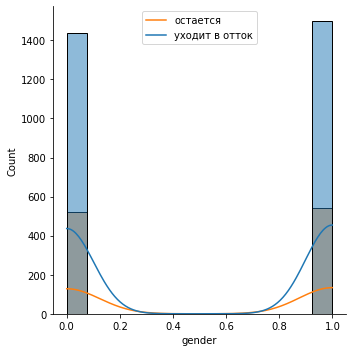

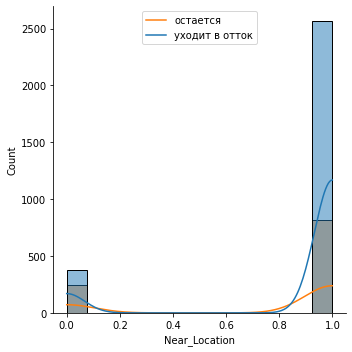

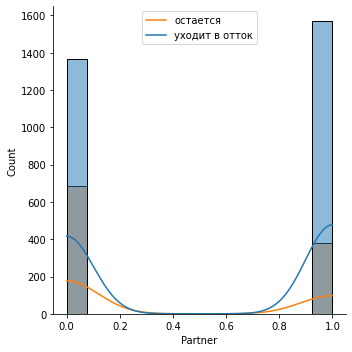

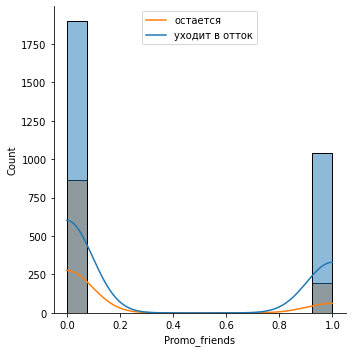

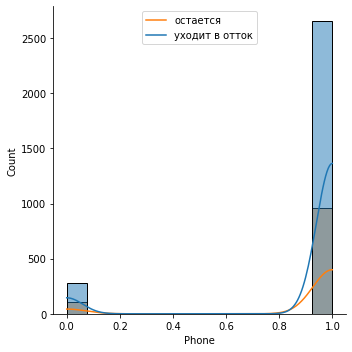

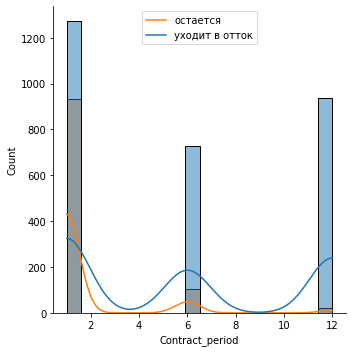

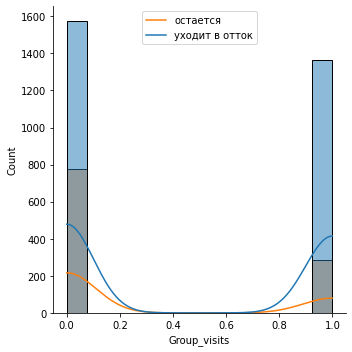

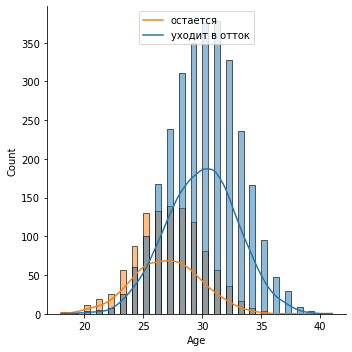

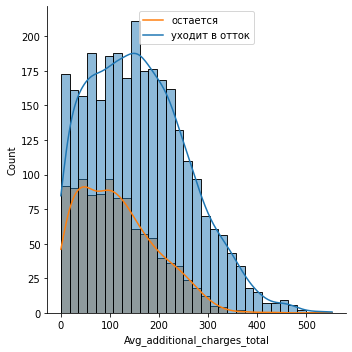

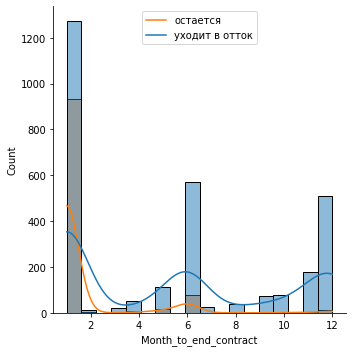

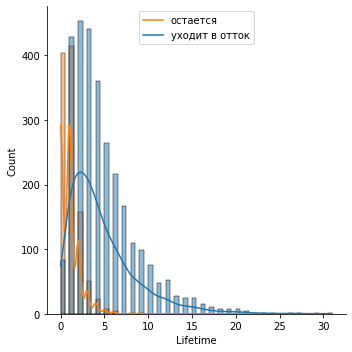

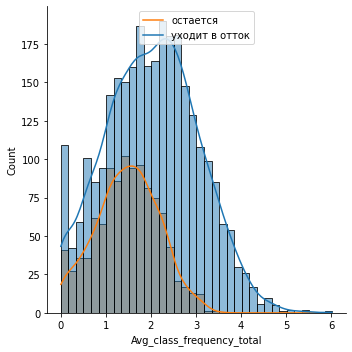

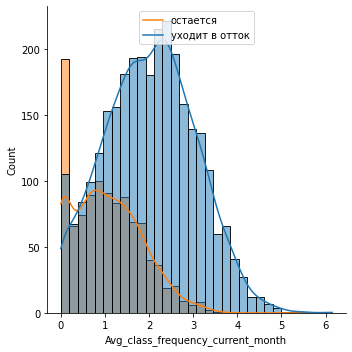

In [8]:
for col in gym_churn.drop('Churn', axis=1).columns:
    sns.displot(data=gym_churn, x=col, kde=True, hue='Churn', legend=False)
    plt.legend(['остается', 'уходит в отток'], loc='upper center')
    plt.show()

Выводы по графикам:
1. Соотношение мужчин и женщин прмерно одинаково для обоих видов.
2. Среди тех, кто остается больше тех, кто живет близко к фитнес-центру, при этом больше пользователей, которые живут рядом.
3. Партнеры компании примерно одинаково уходят и остаются, среди не партнером соотношение останутся уйдут примерно 2 к 1.
4. Среди тех, кто остается больше тех, треть пришли по промокоду с другом. Среди клиентов оттока четверть пришли по промокоду. 
5. Телефон оставляют почти все клиенты в обоих случаях.
6. Среди тех, кто остается покупка абонемента на 1, 6 и 12 месяцев одинаково. Среди тех, кто уходит, большинство покупает абонемент на 1 месяц, редко на 6 месяцев, и совсем редко на 12 месяцев.
7. Среди тех, кто остаются примерно одинаково посещают/ не посещают групповые занятия. Те, кто уходят, реже ходят на групповые занятия.
8. Средний возраст примерно одинаковый, от 20 до 40.
9. Суммарная выручка тоже примерно одинаковая, те, кто остаются тратьят чуть больше.
10. График очень идентичен графику абонемента.
11. Те, кто уходит в среднем посещали фитнес-центр 1-3 месяца, те, кто остаются посещают чуть дольше.
12. Те, кто уходит в среднем реже ходят на занятия 1-3 раза в неделю.
13. По прошлому месяцу, те кто уходят ходили хуже.

Теперь выведу матрицу корреляции

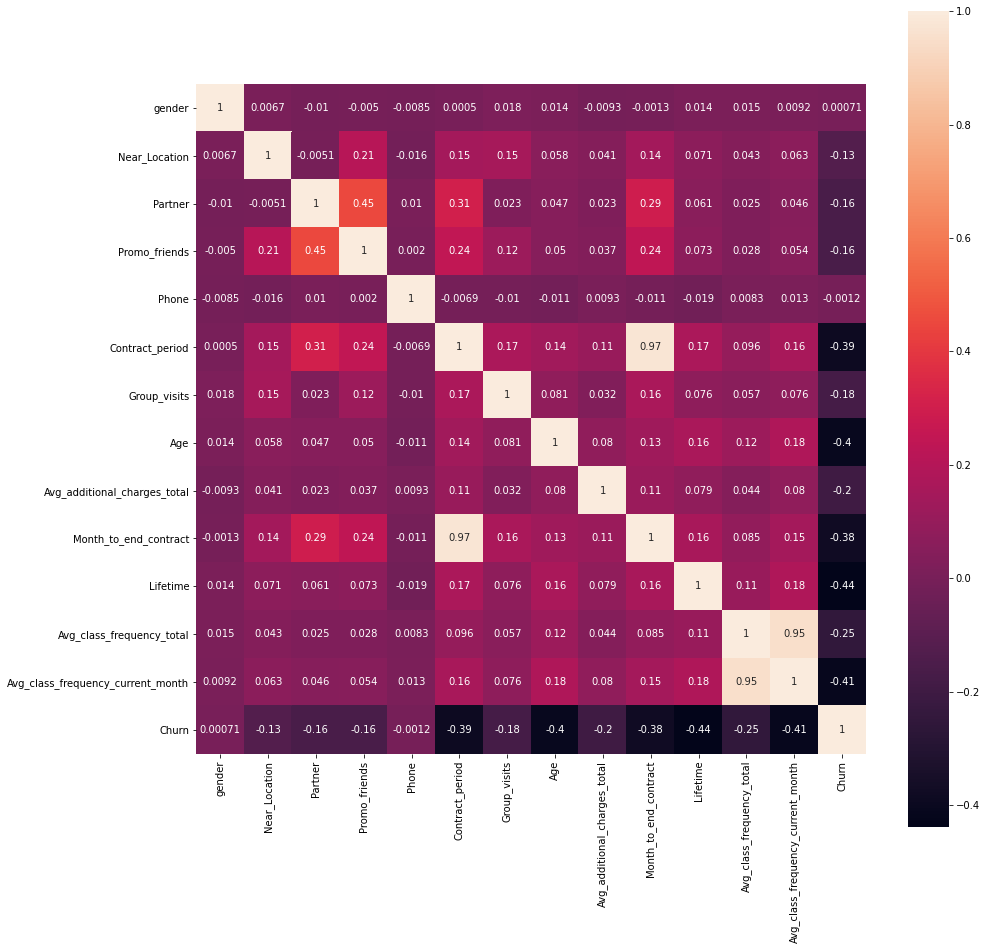

In [9]:
corr_m = gym_churn.corr()
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, square = True, annot = True)
plt.show()

Хорошо коррелируют:
1. Количество месяцев до конца абонемента и абонемент.
2. Колиечство посещений в неделю за этот и предыдущий месяцы.
<br> Можно убрать столбцы абонемент и посещения в предыдущем месяце, если избавляться от мультиколлинеарности. Но учитывая,  модель леса устойчива к мультиколлинеарности, а логистическая регрессиия по умолчанию использует регуляризацию, это делать необязательно.

### Вывод:
1. Соотношение мужчин и женщин прмерно одинаково для обоих видов.
2. Среди тех, кто остается больше тех, кто живет близко к фитнес-центру, при этом больше пользователей, которые живут рядом.
3. Партнеры компании примерно одинаково уходят и остаются, среди не партнером соотношение останутся уйдут примерно 2 к 1.
4. Среди тех, кто остается больше тех, треть пришли по промокоду с другом. Среди клиентов оттока четверть пришли по промокоду. 
5. Телефон оставляют почти все клиенты в обоих случаях.
6. Среди тех, кто остается покупка абонемента на 1, 6 и 12 месяцев одинаково. Среди тех, кто уходит, большинство покупает абонемент на 1 месяц, редко на 6 месяцев, и совсем редко на 12 месяцев.
7. Среди тех, кто остаются примерно одинаково посещают/ не посещают групповые занятия. Те, кто уходят, реже ходят на групповые занятия.
8. Средний возраст примерно одинаковый, от 20 до 40.
9. Суммарная выручка тоже примерно одинаковая, те, кто остаются тратьят чуть больше.
10. Те, кто уходит в среднем посещали фитнес-центр 1-3 месяца, те, кто остаются посещают чуть дольше.
11. Те, кто уходит в среднем реже ходят на занятия 1-3 раза в неделю.

## Модель прогнозирования оттока пользователей

### Разделение данных на признаки и целевую переменную

In [10]:
X = gym_churn.drop('Churn', axis = 1)
y = gym_churn['Churn']

### Разделение данных на обучающую и валидационную выборку

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
print('Размер обучающей выборки: {} строк - {:.0%}'.format(X_train.shape[0], X_train.shape[0]/X.shape[0]))
print('Размер валидационной выборки: {} строк - {:.0%}'.format(X_test.shape[0], X_test.shape[0]/X.shape[0]))

Размер обучающей выборки: 3200 строк - 80%
Размер валидационной выборки: 800 строк - 20%


С разделением все хорошо.

Обучать модель на train-выборке будем двумя способами:
-	логистической регрессией
-	случайным лесом
<br> Для обучения необходимо стандартизировать данные.

### Стандартизация обучающей и валидационной выборок

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### Обучение модели на train-выборке логистической регрессией

In [14]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

### Обучение модели на train-выборке случайным лесом

In [15]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

### Сравнение моделей

Выведу метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

Метрика accuracy - доля правильных ответов
<br> Долю правильных ответов вычисляют так:
<br> $$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

Метрика precision - Точность (доля правильных ответов только среди целевого класса)
<br> Точность вычисляют так:
<br> $$Precision = \frac{TP}{TP + FP}$$

Метрика recall - полнота (сколько реальных объектов "1" класса обнаружено с помощью модели)
<br> Полноту вычисляют так:
<br> $$Recall = \frac{TP}{TP + FN}$$

F1-мера метрика, учитывающая баланс между метриками precision и recall.
<br> Вычисляют так:
<br> $$Recall = \frac{2 * precision * recall}{precision + recall}$$

Метрика roc_auc - площадь под кривой ошибок

In [16]:
print_all_metrics(y_test, lr_predictions, lr_probabilities, title='Метрики классификации логистической регрессией')

Метрики классификации логистической регрессией
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97


In [17]:
print_all_metrics(y_test, rf_predictions, rf_probabilities, title='Метрики классификации случайного леса')

Метрики классификации случайного леса
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	F1: 0.83
	ROC_AUC: 0.97


### Вывод:
1. Доля правильных ответов 92% для обеих моделей
2. Точность и полнота у случайного леса выше, чем у логистической регрессии.
3. Дополнительная f1-метрика лучше у логистической регрессии.
4. А roc_auc одинаков.
<br> С учетом всех метрик, логистическая регрессия лучше, чем случайный лес.

## Кластеризация пользователей

### Стандартизизация данных

In [18]:
X_sc = scaler.fit_transform(X)

### Матрица расстояний и дендрограмма

In [19]:
# матрица расстояний
linked = linkage(X_sc, method = 'ward') 

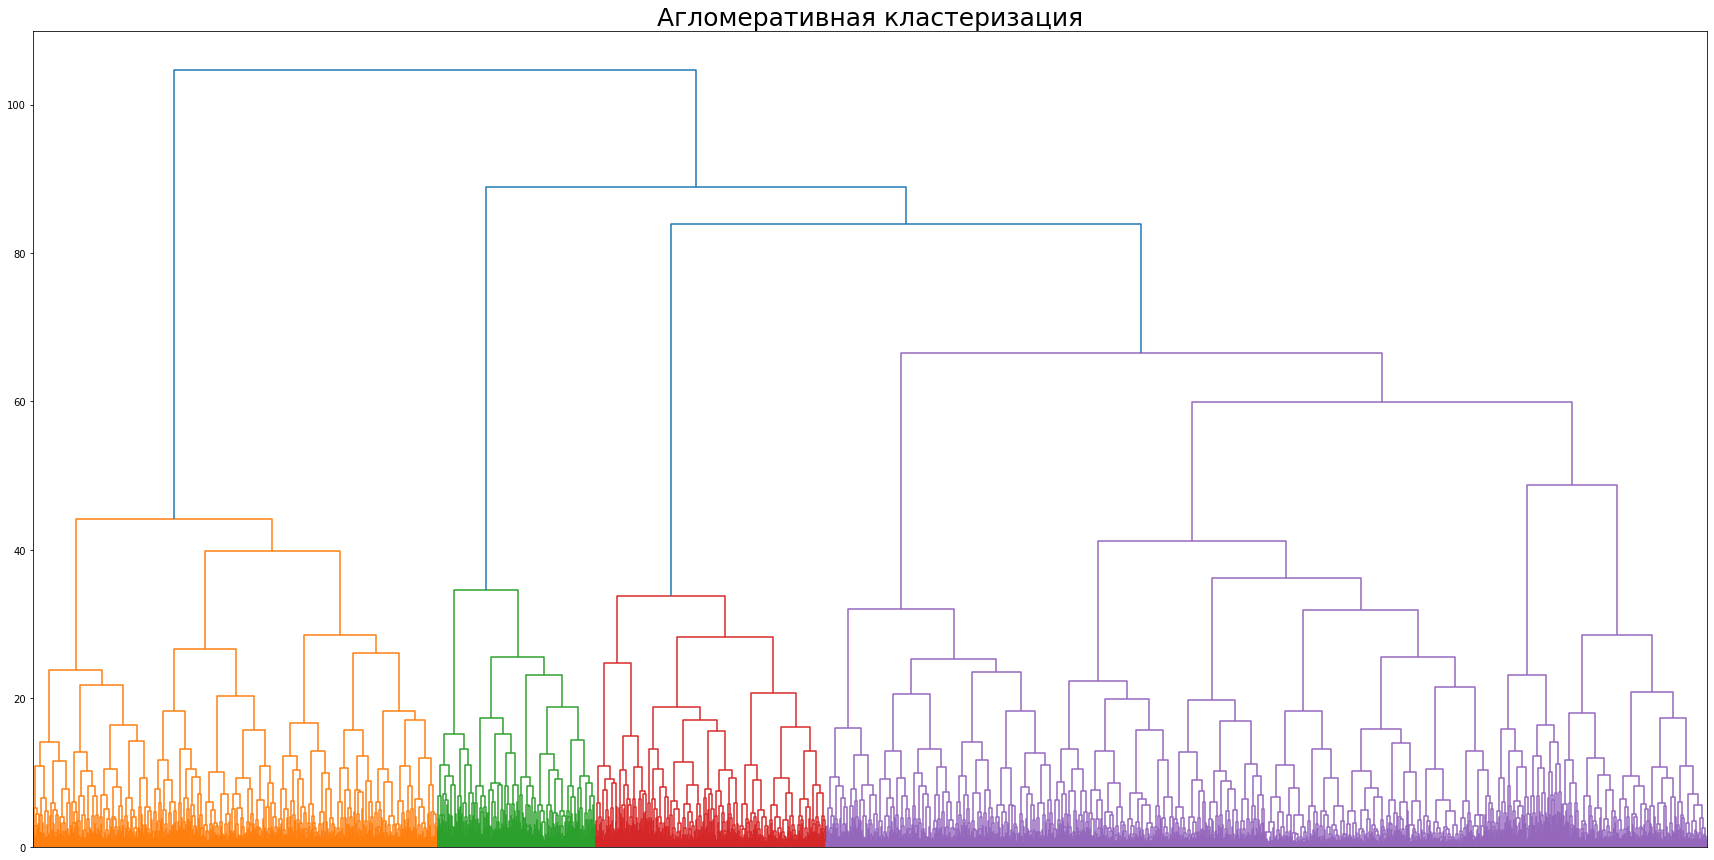

In [20]:
# дендрограмма
plt.figure(figsize=(30, 15))  
dendrogram(linked, orientation='top')
plt.title('Агломеративная кластеризация', fontsize=25)
plt.xticks([]) #убрала подписи признаков, т к это сплошная полоса и даде наклоном их не разделить
plt.show() 

Предложенное оптимальное число кластеров 4.

### Модель кластеризации на основании алгоритма K-Means 

In [21]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)
# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

In [22]:
# выводим статистику по средним значениям наших признаков по кластеру
gym_churn.groupby(['cluster_km']).mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


Кластеры различаются по признакам:
1. Кроме 2 кластера большинство живут рядом с фитнес-центром
2. Доля сотрудников компаний-партнеров 0 - почти 80%, остальные - около 40%
3. Промокод друга 3 - менее 10%, 1б 3, 4 - около 30%, 0 - около 60%
4. Указание телефона у 1 кластера - 0%, у остальных - 100%
5. Абонемент у 0 - большинство 12 месяцев, 1 - 6 месяцев, у остальных большинство 1 месяц
6. У 0 кластера у большинства абонемент на 12 месяцев, у 1 - 6 месяцев, у остальных 1 и 3 месяца
7. По посещениям групповых занятий небольшая разница между кластерами
8. Возраст тоже небольшая разница
9. Среднее значение потраченной суммы тоже примерно в одном диапазоне
10. Остаток абонемента 1, 2 и 3 - менее 3 месяцев, 4 - менее 5 месяцев, 0 - около 10 месяцев
11. По времени с начала посещения тоже небольшие различия, 3 - 2 месяца, 2 - почти 3 месяца, 1 - около 4 месяцев, 0 и 4 - почти 5 месяцев
12. Количество посещений почти не отличается
13. Отток почти нулевой у 0 и 4 кластеров, маленький у 1, около 50% у 2 и 3

Распределения признаков для кластеров

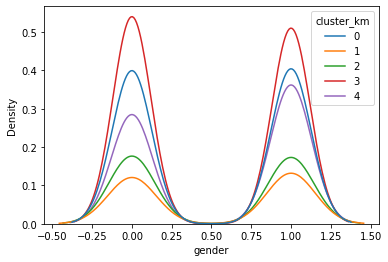

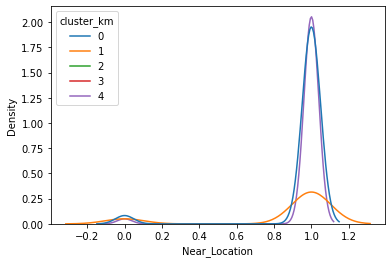

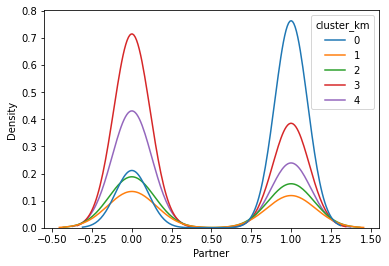

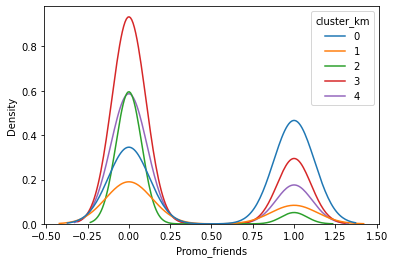

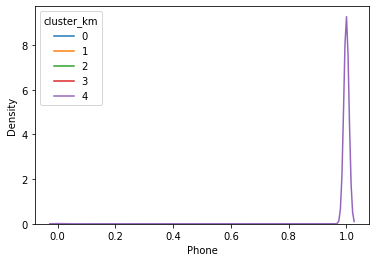

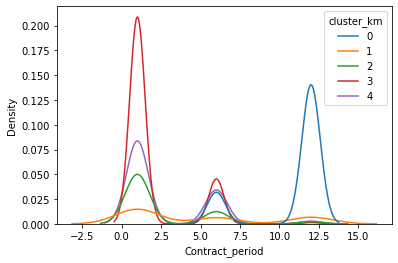

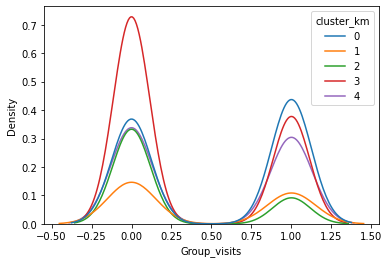

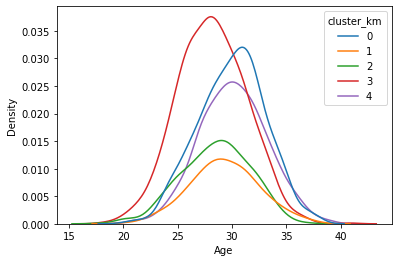

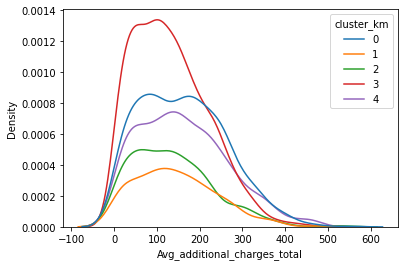

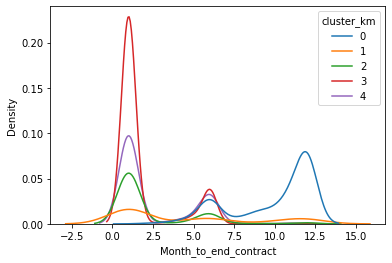

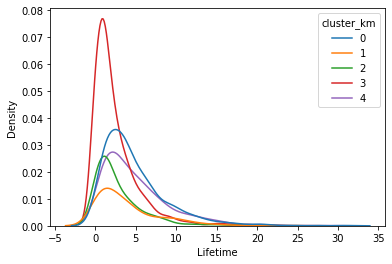

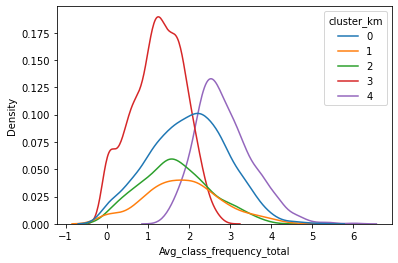

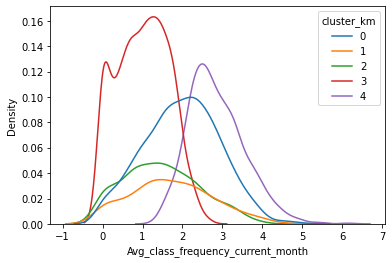

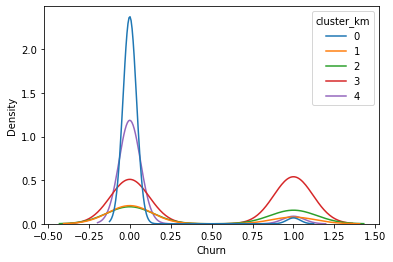

In [23]:
for col in gym_churn.drop('cluster_km', axis=1).columns:
    sns.kdeplot(data=gym_churn, x=col, hue='cluster_km', legend=True, palette="tab10")
    plt.show()

Графики подтверждают выводы по таблицам

Можно выделить характерные черты по кластерам:
<br> 0 кластер: живут рядом, сотрудники компании-партнера, все пришли по промокоду друга, оставили номер телефона, абонемент на 12 месяцев, половина посещают групповые занятия, самый маленький отток
<br> 1 кластер: живут рядом, половина сотрудники комании партнера, без промокодов, не оставили номер телефона, абонемент примерно на 6 месяцев, примерно половина посещает групповые занятия, 26% уходят в отток
<br> Здесь стоит разобраться в причинах отттока, может предложить промокод
<br> 2 кластер: далеко живут, половина сотрудники комании-партнера, почти не использовали промокоды, маленький период абонемента, хуже всех посещают групповые занятия, половина уходят в оттток 
<br> Здесь причиной оттока может быть дальность расположения фитнес-центра
<br> 3 кластер: живут рядом, 35% сотрудники компании-партнера, у 24% есть промокод, оставили номер телефона, самый маленький период абонемента, 34% посещают групповые занятия, недолго ходят, самый большой отток
<br> Может в этот кластер вошли те, кто начинает с понедельника новую жизнь? Кластер похож на 4, различаются лишь отттоком
<br> 4 кластер: живут рядом, 35% сотрудники компании-партнера, у 23% есть промокод,  маленький период абонемента, оставили номер телефона, почти половина посещают групповые занятия, долго ходят, маленький отток

Доля оттока для каждого полученного кластера

In [24]:
df = gym_churn.groupby('cluster_km').agg({'Churn': 'sum'})
df['Churn'] = df['Churn']/df['Churn'].sum()
df.sort_values(by='Churn', ascending=False)

,Churn
cluster_km,
3,0.611687
2,0.211122
1,0.097078
4,0.053723
0,0.026390


Самая высокая доля оттока от общего у 3 кластера - 61%, непонятно почему
<br> На втором месте 2 кластер - 21% от общего, здесь причиной может быть дальность расположения фитнес-центра
<br> На остальные кластера в сумме приходится 16% от общего

### Вывод:
<br> **0 кластер**: живут рядом, сотрудники компании-партнера, все пришли по промокоду друга, оставили номер телефона, абонемент на 12 месяцев, половина посещают групповые занятия, самый маленький отток - **2% от общего отттока**
<br> **1 кластер**: живут рядом, половина сотрудники комании партнера, без промокодов, не оставили номер телефона, абонемент примерно на 6 месяцев, примерно половина посещает групповые занятия, 26% уходят в отток - **9% от общего отттока**
<br> Здесь стоит разобраться в причинах отттока, может предложить промокод
<br> **2 кластер**: далеко живут, половина сотрудники комании-партнера, почти не использовали промокоды, маленький период абонемента, хуже всех посещают групповые занятия, половина уходят в оттток  - **21% от общего отттока**
<br> Здесь причиной оттока может быть дальность расположения фитнес-центра
<br> **3 кластер**: живут рядом, 35% сотрудники компании-партнера, у 24% есть промокод, оставили номер телефона, самый маленький период абонемента, 34% посещают групповые занятия, недолго ходят, самый большой отток - **61% от общего отттока**
<br> Причины оттока непонятны. По признакам кластер похож на 4, различаются лишь отттоком.
<br> **4 кластер**: живут рядом, 35% сотрудники компании-партнера, у 23% есть промокод,  маленький период абонемента, оставили номер телефона, почти половина посещают групповые занятия, долго ходят, маленький отток - **5% от общего оттока**

##  Общий вывод:
1. На отток влият признаки:
- проживание в близи фитнес-центра
- наличие промокода
- посещение групповыъх зянятий
<br>
2. Для прогнозирования оттока были выбраны модели логистическая регрессия и случайный лес, после сравнения метрик логистическая регрессия оказаась чуть лучше.
<br>
3. Кластеризация выделила 5 видов клиентов (оставила лишь ключевые 3 признака):
<br> **0 кластер**: живут рядом, все пришли по промокоду друга, половина посещают групповые занятия, самый маленький отток - **2% от общего отттока**
<br> **Рекомендация:** Этот кластер с самыми надеждными клиентами, можно ничего не предпринимать. 
<br> **1 кластер**: живут рядом,  без промокодов, примерно половина посещает групповые занятия, 26% уходят в отток - **9% от общего отттока**
<br> **Рекомендация:**  В этом кластере небольшой отток, учитывая отсутствие промокодов, для удуржания можно попробовать предложить его. 
<br> **2 кластер**: далеко живут, почти не использовали промокоды, хуже всех посещают групповые занятия, половина уходят в отток  - **21% от общего отттока**
<br> **Рекомендация:** Здесь причиной оттока может быть дальность расположения фитнес-центра, на этот фактор трудно повлиять.
<br> **3 кластер**: живут рядом, у 24% есть промокод, 34% посещают групповые занятия, недолго ходят, самый большой отток - **61% от общего отттока**
<br> **Рекомендация:**  Причины оттока непонятны. По признакам кластер похож на 4, различаются лишь отттоком. Можно предложить им промокод для друга, попробовать увеличить посещение групповых занятий. 
<br> **4 кластер**: живут рядом, у 23% есть промокод, почти половина посещают групповые занятия, маленький отток - **5% от общего оттока**
<br> **Рекомендация:** Этот кластер с маленьким оттоком, можно ничего не предпринимать.